In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
import random
# import seaborn as sns
import scipy.signal as ss
from scipy.special import i0
from scipy.ndimage import convolve1d
# from matplotlib import animation
# from matplotlib import rc as matrc
# matrc('animation', html='jshtml', embed_limit=20971520*2)
# import matplotlib.patches as patches

In [2]:
import Ipynb_importer
import familiarity_functions

importing Jupyter notebook from familiarity_functions.ipynb


In [5]:
# Generating the stimuli
img_dir = 'tang_stimuli/pattern_images/'

# When I want to test something:
# img_idx = np.linspace(0, 9500, endpoint = False, num = 50, dtype = int)

# all stimuli:
img_idx = np.arange(9500, dtype = int)

num_stimuli = len(img_idx)
img_wid = 160 # the original size of pattern images is 160
img_len = 160
pooling_wid = 1
pooling_len = 1
img_s_wid = int(np.ceil(img_wid / pooling_wid))
img_s_len = int(np.ceil(img_len / pooling_len))
img = np.zeros((num_stimuli, img_s_wid, img_s_len))

wid_rf = 52
len_rf = 52
overlap = 18


def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
    gray = gray / np.max(gray)
    return gray

def del_edges(img, edge_threshold):
    # up, down, left, right
    # white is 1, black is 0
    if (img[:edge_threshold, 0].all() == 0):
        count = edge_threshold
        while (img[count, 0] == 0):
            count += 1
        img = img[count:, :]
    if (img[-edge_threshold:, 0].all() == 0):
        count = edge_threshold
        while (img[-(count+1), 0] == 0):
            count += 1
        img = img[:-count, :]
    if (img[0,:edge_threshold].all() == 0):
        count = edge_threshold
        while (img[0, edge_threshold] == 0):
            count += 1
        img = img[:, count:]
    if (img[0, -edge_threshold:].all() == 0):
        count = edge_threshold
        while (img[0, -(count+1)] == 0):
            count += 1
            img = img[:, :-count]
    return img

def center(img, size):
    indent =np.array((np.array(np.shape(img)) - size)/2).astype(int)
    return img[indent[0]:-(np.shape(img)[0]-size[0]-indent[0]), indent[1]:-(np.shape(img)[1]-size[1]-indent[1])]


# plt.figure()
# plt.set_cmap('gray') # white is 1, black is 0
# for i in range(num_stimuli):
#     img[i,:,:] = familiarity_functions.pooling(np.ones((img_wid, img_len)) -\
#                                                mpimg.imread(img_dir + '%d.png' %img_idx[i]), [pooling_wid, pooling_len])
    # ax = plt.subplot(1, num_stimuli, i + 1)
    # plt.imshow(img[i])
    # rect1 = patches.Rectangle((11.5, 11.5), wid_rf, len_rf,linewidth=1,edgecolor='r',facecolor='none')
    # ax.add_patch(rect1)
    
num_row = int((img_s_wid - wid_rf)/overlap) + 1
num_col = int((img_s_len - len_rf)/overlap) + 1
num_hyper = num_row * num_col
print('Number of hypercolumns = %d' %num_hyper)
print('Number of stimuli = %d' %num_stimuli)

Number of hypercolumns = 49
Number of stimuli = 9500


In [6]:
# Parameters regarding the Gabor filters

gabor_size = [wid_rf, len_rf]

num_orient = 8
orientation = np.linspace(-np.pi/2, np.pi/2, num_orient, endpoint=False)

# in version 8:
# spat_freq = [0.5, 1.0] # similar to the derivative order
# sigma_deno = [10.0, 20.0] # similar to the aspect ratio

# in version 15:
spat_freq = [1.0] # similar to the derivative order
sigma_deno = [10.0] # similar to the aspect ratio

num_kernel = 2 * num_orient * len(spat_freq) * len(sigma_deno) # cos and sin

In [7]:
# Generate Gabor Filters
gabor_arr_cos = np.zeros((len(spat_freq) * len(sigma_deno), wid_rf, len_rf, num_orient))
gabor_arr_sin = np.zeros((len(spat_freq) * len(sigma_deno), wid_rf, len_rf, num_orient))
for i in range(len(spat_freq)):
    for j in range(len(sigma_deno)):
        gabor_arr_cos[i*len(sigma_deno)+j], gabor_arr_sin[i*len(sigma_deno)+j] = \
        familiarity_functions.gabor2D_Lee(gabor_size, orientation, sigma_deno[j], spat_freq[i])

# check the generated gabor filters
# black means negative, white means positive
# gabor_max = np.amax(gabor_arr_cos)
# gabor_min = np.amin(gabor_arr_cos)
# plt.figure()
# plt.set_cmap('gray')
# for i in range(len(spat_freq)):
#     for j in range(len(sigma_deno)):
#         plt.subplot(len(spat_freq), len(sigma_deno), i*len(sigma_deno)+j+1)
#         plt.title("spat_freq=%f" %spat_freq[i])
#         plt.imshow(gabor_arr_cos[i*len(sigma_deno)+j,:,:,0], vmax=gabor_max, vmin=gabor_min)

# # check the generated gabor filters
# # black means negative, white means positive
# gabor_max = np.amax(gabor_arr_sin)
# gabor_min = np.amin(gabor_arr_sin)
# plt.figure()
# plt.set_cmap('gray')
# for i in range(len(spat_freq)):
#     for j in range(len(sigma_deno)):
#         plt.subplot(len(spat_freq), len(sigma_deno), i*len(sigma_deno)+j+1)
#         plt.title("spat_freq=%f" %spat_freq[i])
#         plt.imshow(gabor_arr_sin[i*len(sigma_deno)+j,:,:,0], vmax=gabor_max, vmin=gabor_min)
        
# print(gabor_max)
# print(gabor_min)

In [8]:
# kernel order: cos, sin
gabor_arr = np.zeros((2 * len(spat_freq) * len(sigma_deno) * num_orient, wid_rf, len_rf))
for i in range(num_orient):
    gabor_arr[i * len(spat_freq) * len(sigma_deno):(i+1) * len(spat_freq) * len(sigma_deno)] = gabor_arr_cos[:,:,:,i]
    gabor_arr[(i+num_orient)*len(spat_freq)*len(sigma_deno):(i+1+num_orient) * len(spat_freq) * len(sigma_deno)] = gabor_arr_sin[:,:,:,i]

print(np.shape(gabor_arr))

(16, 52, 52)


In [ ]:
# Generating the feedforward input using sparse coding

stride = [overlap, overlap] # displacement between neighboring kernels

# simple cells
response = np.zeros((num_stimuli, num_kernel, num_row, num_col))
learning_rate = 0.0016 # from the original code
delta = np.zeros(num_kernel)
num_iteration = 20 # from the original code
penalty = 0.0

num_r_in_report = 10
for num in range(num_stimuli):
    if (num % num_r_in_report == 0):
        print("Stimulus: %d"%num)
    for i in range(num_row):
        for j in range(num_col):
            image_patch = img[num, stride[0]*i:stride[0]*i+gabor_size[0], stride[1]*j:stride[1]*j+gabor_size[1]]
            for ite in range(num_iteration):
                summed = np.zeros((gabor_size[0], gabor_size[1]))
                for g in range(num_kernel):
                    summed = summed + np.multiply(response[num, g, i, j], gabor_arr[g])
                for k in range(num_kernel):
                    delta[k] = 2 * np.dot((image_patch - summed).flatten(), gabor_arr[k].flatten())
                delta = delta - penalty * np.sign(response[num, :, i, j])
                response[num, :, i, j] = response[num,:, i, j] + learning_rate * delta
                # check the loss
                # print(np.sum(delta))

r_in = np.zeros((num_stimuli, int(num_kernel/2), num_row, num_col))
for i in range(int(num_kernel/2)):
    r_in[:,i,:,:] = response[:,i,:,:] ** 2 + response[:,i+int(num_kernel/2), :,:] ** 2

In [8]:
np.save("cluster_results/test_on_pattern_22/r_in_all", r_in)

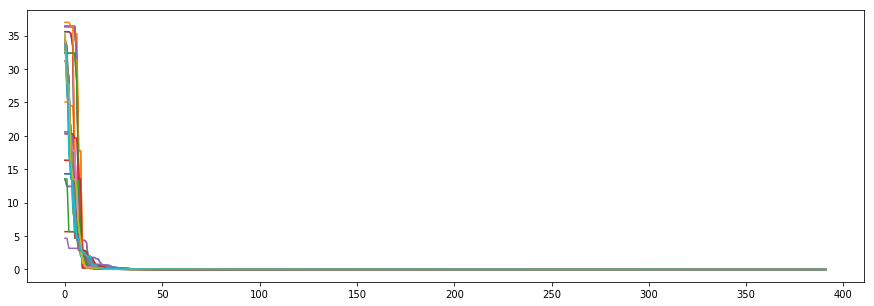

In [9]:
plt.figure(figsize = (15,5))
for i in range(50):
    plt.plot(np.flip(np.sort(r_in[i].flatten() * 350.0), 0))

In [9]:
num_stimuli = 9500
gamma = 350.0
N_e = int(num_kernel / 2) * num_row * num_col
r_in = np.reshape(np.load("cluster_results/test_on_pattern_22/r_in_all.npy"), (num_stimuli, N_e)) * gamma
# lower_bound = 1.0
# threshold_BCM = np.zeros(N_e)
# for i in range(N_e):
#     threshold_BCM[i] = np.mean(np.square(r_in[r_in[:, i] > lower_bound,i]))
ys_before = np.load("cluster_results/test_on_pattern_22/ys_before.npy")
save_every_stim = 5

def r(ui, beta, t=0.0):
    return np.maximum(ui - t, 0) * beta

beta = 1.0
threshold_BCM = np.mean(np.square(r(ys_before[np.arange(save_every_stim, (num_stimuli+1)*save_every_stim, save_every_stim), :N_e], beta)), axis = 0)


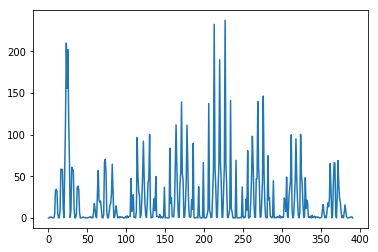

In [10]:
plt.plot(threshold_BCM)

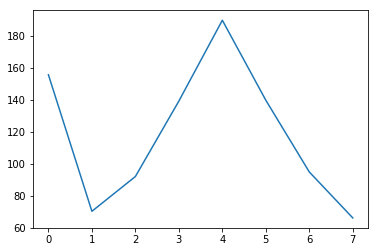

In [11]:
# check the BCM threshold for the center hypercolumn
center_idx = familiarity_functions.take_center(np.arange(N_e), num_kernel // 2, num_row, num_col, 1)
plt.plot(threshold_BCM[center_idx])
a = np.repeat(threshold_BCM[center_idx], num_row * num_col)
# np.save("cluster_results/test_on_pattern_15/threshold_BCM.npy", a)

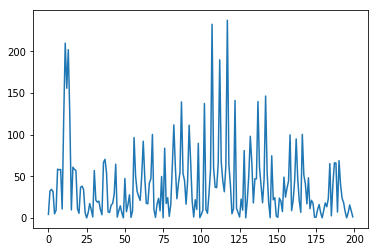

In [12]:
# check the BCM threshold for the center 3-by-3 hypercolumns
center_idx = familiarity_functions.take_center(np.arange(N_e), num_kernel // 2, num_row, num_col, 5)
plt.plot(threshold_BCM[center_idx])

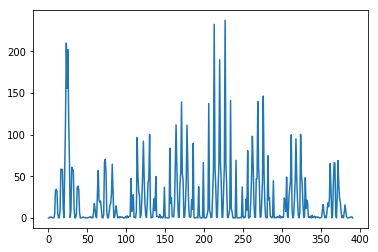

In [13]:
# check the BCM threshold for the center 3-by-3 hypercolumns
center_idx = familiarity_functions.take_center(np.arange(N_e), num_kernel // 2, num_row, num_col, 7)
plt.plot(threshold_BCM[center_idx])

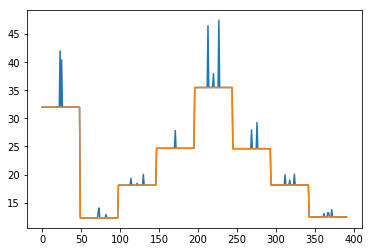

In [28]:
a = np.reshape(threshold_BCM[center_idx], (num_kernel // 2, 7*7))
b = np.mean(a, axis = 1)
# plt.plot(np.load("cluster_results/test_on_pattern_22/threshold_BCM.npy"))
# # np.save("cluster_results/test_on_pattern_22/threshold_BCM", np.repeat(b, num_row * num_col))
# plt.plot(np.load("cluster_results/test_on_pattern_15/threshold_BCM_in_18.npy"))
# plt.plot(b)
c = np.maximum(threshold_BCM[center_idx] / 5, np.repeat(b, num_row * num_col))
plt.plot(c)
plt.plot(np.repeat(b, num_row * num_col))
np.save("cluster_results/test_on_pattern_22/threshold_BCM_2", c)

In [11]:
c = np.mean(b)
print(c)
np.save("cluster_results/test_on_pattern_15/threshold_BCM_in_18_all_average", np.repeat(c, N_e))

18.88123178788091


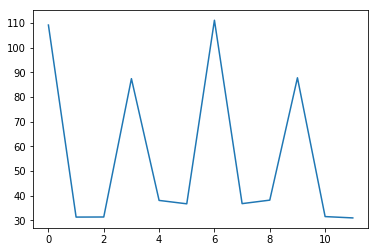

In [25]:
ys_before = np.load("cluster_results/test_on_pattern_15/ys_before.npy")
save_every_stim = 5
top_num = 10
max_response = np.empty(N_e)

for i in range(N_e):
    arr = r(ys_before[np.arange(save_every_stim, (num_stimuli+1)*save_every_stim, save_every_stim), i], beta)
    max_response[i] = np.mean(arr[np.argpartition(arr, -top_num)[-top_num:]])

d = np.reshape(max_response, (num_kernel // 2, 7*7))
e = np.mean(d, axis = 1)
plt.plot(e)

IndexError: index 50 is out of bounds for axis 0 with size 50

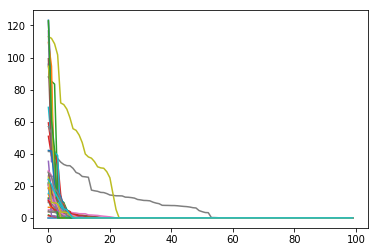

In [28]:
N_e = int(num_kernel / 2) * num_row * num_col
ys_before = np.load("cluster_results/test_on_pattern_15/ys_before_in_16.npy")[img_idx, :N_e]
for i in range(num_stimuli):
    plt.plot(np.flip(np.sort(ys_before[i]), 0)[:100])